# Objective 

In this tutorial, we will be embarking on a large endeavor to compare theory and experiment in the context of gene expression in *E. coli*. In lecture, we derived a mathematical prediction of how the expression of a reporter gene (YFP) should change in response to increasing copy number of the LacI repressor. Here, we will make plots of our predictions as well as go through all the data analysis needed to plot the data on top of our theory to see how they compare.

# Part 1: Using phase images to get segmentation masks

At the end of the day, we are interesting in determining the amount of YFP expression in *E. coli* with varying copy numbers of the repressor, LacI. Before we can assess the amount of fluorescence, we first need to find where the cell are in the images. To do this, it's important to use a channel that is independent of the reporter gene, so we will be using phase images to get our segmentation masks. 

## 1.1: Background subtraction

Let's first look at a sample image.

In [ ]:
# import the usual 
import numpy as np
import matplotlib.pyplot as plt
import requests
import zipfile
%matplotlib inline

# for nice plots
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14, \
    'xtick.labelsize' : 14, 'ytick.labelsize' : 14}
sns.set(style='ticks', rc=rc)

# show images in viridis by default
plt.rcParams['image.cmap'] = 'viridis'

# for extracting filenames
import glob

# skimage submodules we need
import skimage.io
import skimage.measure
import skimage.filters
import skimage.exposure

First, we need to download the image files from the RP lab course data.

In [ ]:
r=requests.get('http://rpdata.caltech.edu/courses/course_data/lacI_titration.zip')

filename = "laci_data.zip"
with open(filename, mode="wb") as localfile:
  localfile.write(r.content)

with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('.')

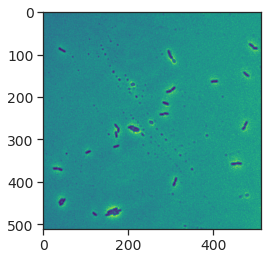

In [ ]:
# Read an example phase contrast image
im = skimage.io.imread('lacI_titration/O2_R124_phase_pos_02.tif')

# Show the image
plt.imshow(im)

This image is noisy and unevenly illuminated, where the top right corner is brighter than the bottom left. This gradient of pixel intensity, is not biologically relevant, and is actually something we would like to remove. We can fix this by *background subtracting* the image. To get the "background" we need to blur the image, removing any fine-detail structures (like the bacteria). 

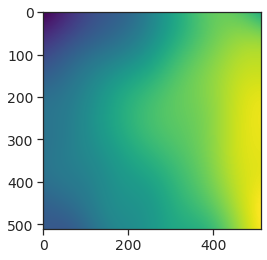

In [ ]:
# normalize it
im_float = (im - np.min(im))/(np.max(im)-np.min(im))

# find the background
gauss_radius = 50
im_bg = skimage.filters.gaussian(im_float, sigma=gauss_radius)

# show the background
plt.imshow(im_bg)

Now that we have the background image, we can subtract it from the original image.

Text(0.5, 1.0, 'background-subtracted image')

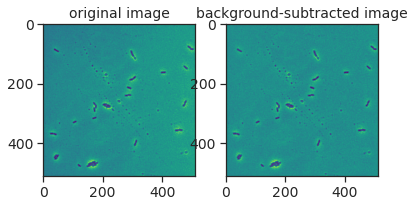

In [ ]:
# perform a background subtraction
im_bs = im_float - im_bg

# show the background-subtracted image
fig, ax = plt.subplots(1,2)
ax[0].imshow(im_float)
ax[0].set_title('original image')

ax[1].imshow(im_bs)
ax[1].set_title('background-subtracted image')

Nice! We can see that the background of our background-subtracted image is a lot more even now. 

## 1.2: Thresholding

Now that we have cleaned up the image a little bit, we can start to distinguishing bacteria from background. We will do these by *thresholding* the image, similar to how we did [on the first day](bacterial_growth.html). To figure out a good threshold, let's plot the histogram of pixel intensities. 

Text(0, 0.5, 'count')

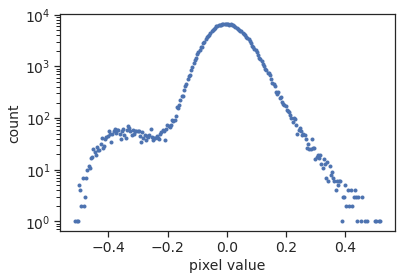

In [ ]:
hist, pixel_vals = skimage.exposure.histogram(im_bs)

plt.plot(pixel_vals, hist, '.')
plt.yscale('log')
plt.xlabel('pixel value')
plt.ylabel('count')

By plotting with the $y$-axis logarithmically scaled, we can distinguish one hump of low pixel intensities (bacteria) from another hump of high pixel intensities (background). There is a sharp transition around $-0.2$ where we transition from bacteria to background, and we will use this as our threshold. 

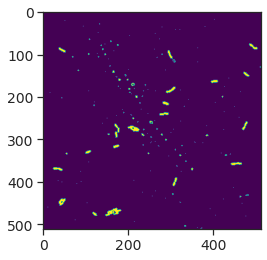

In [ ]:
# Choose a threshold
threshold = -0.2

# Thresholded image
im_thresh = im_bs < threshold

# Show the thresholded image
plt.imshow(im_thresh)

## 1.3: Label and get sizes of the objects in the image

Our thresholding did okay, but we see we have a lot of single pixels and a lot of clumps that don't correspond to individual bacteria. To remove these features that don't correspond to the bacteria, we will first *label* the image using `skimage.measure.label()`. This function will look for contiguous islands of $1$ pixels in our labeled image and assign each island as an object. Let's label our image and plot the result.

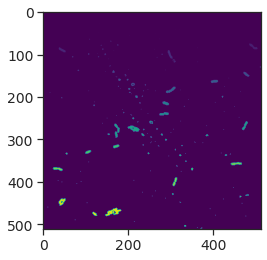

In [ ]:
# label the objects in the binary image
im_label = skimage.measure.label(im_thresh)

# show the labeled image in a colored scale
plt.imshow(im_label)

Next, we need to remove small things that are not bacteria and large things that are clumps of bacteria

Text(0, 0.5, 'counts')

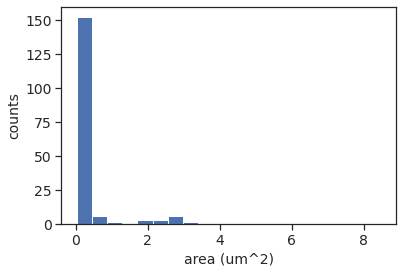

In [ ]:
#remove things that are not single cells
pixel_size = 0.16 #um

areas = []

objs = skimage.measure.regionprops(im_label)

for obj in objs:
  areas = np.append(areas, obj.area * pixel_size**2)

plt.hist(areas, bins=20)
plt.xlabel('area (um^2)')
plt.ylabel('counts')

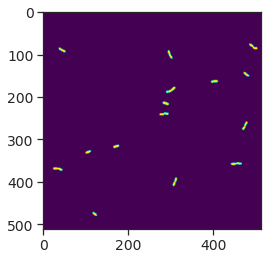

In [ ]:
lower_area = 1
upper_area = 4

im_mask = np.zeros_like(im_label)

for i in range(len(areas)):

  area = areas[i]

  if (area > lower_area) and (area < upper_area):
    im_mask = im_mask + (im_label == objs[i].label)

  plt.imshow(im_mask)

In [ ]:
im_mask_label = skimage.measure.label(im_mask)

print(im_mask_label.max(), 'objects remaining')

15 objects remaining


In [ ]:
def create_mask(phase_image, gauss_radius = 50, threshold = -0.2, \
                pixel_size = 0.16, area_low = 1, area_high = 4):
  #normalize
  im_float = (phase_image - np.min(phase_image))/(np.max(phase_image) - np.min(phase_image))

  #find the background
  im_bg = skimage.filters.gaussian(im_float, gauss_radius)

  #subtract background
  im_gauss = im_float - im_bg

  #threshold
  im_thresh = im_gauss < threshold

  #label image
  im_label = skimage.measure.label(im_thresh)

  #obtain features
  objs = skimage.measure.regionprops(im_label)

  #remove small and large things
  im_mask = np.zeros_like(im_label)
  for obj in objs:
    area = obj.area * pixel_size**2
    if (area > area_low) and (area < area_high):
      im_mask = im_mask + (im_label == obj.label)
    
  #label the mask
  im_mask_label = skimage.measure.label(im_mask)

  return im_mask_label


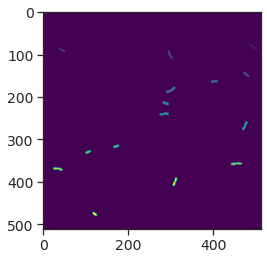

In [ ]:
im_mask_label = create_mask(im)

plt.imshow(im_mask_label)

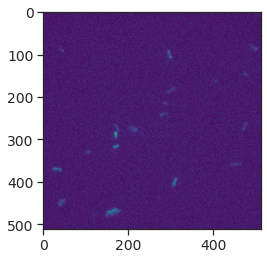

In [ ]:
im_yfp = skimage.io.imread('lacI_titration/O2_R124_yfp_pos_02.tif')

plt.imshow(im_yfp)

In [ ]:
intensities = []

n_cells = np.max(im_mask_label)

for i in range(1, n_cells):

  cell_mask = (im_mask_label == i)

  cell_yfp = cell_mask * im_yfp

  num_pixels = np.sum(cell_mask)
  cell_mean_intensity = np.sum(cell_yfp) / num_pixels

  intensities = np.append(intensities, cell_mean_intensity)

In [ ]:
print(intensities)

[219.09174312 190.18181818 297.1980198  196.32       178.13483146
 201.98449612 194.18390805 208.57943925 202.95145631 361.94871795
 216.84057971 200.69047619 304.02631579 327.93137255]


In [ ]:
def find_intensities(im_phase, im_yfp):

  im_mask_label = create_mask(im_phase)

  intensities = []

  n_cells = np.max(im_mask_label)

  for i in range(1, n_cells):

    cell_mask = (im_mask_label == i)

    cell_yfp = cell_mask * im_yfp

    num_pixels = np.sum(cell_mask)
    cell_mean_intensity = np.sum(cell_yfp) / num_pixels

    intensities = np.append(intensities, cell_mean_intensity)

  return intensities


In [ ]:
intensities = find_intensities(im, im_yfp)

print(intensities)

[219.09174312 190.18181818 297.1980198  196.32       178.13483146
 201.98449612 194.18390805 208.57943925 202.95145631 361.94871795
 216.84057971 200.69047619 304.02631579 327.93137255]
